Kết tập (Aggregating) là hành động thu thập, gom nhóm các đối tượng và là nền tảng của phân tích dữ liệu lớn. Trong một aggregation, bạn sẽ chỉ định một khóa hoặc nhóm và một hàm kết tập đặc tả cách bạn nên chuyển đổi một hoặc nhiều cột. Hàm này phải tạo ra một kết quả cho mỗi nhóm với nhiều giá trị đầu vào cho trước. Khả năng tổng hợp của Spark rất tinh vi và mạnh mẽ, với nhiều trường hợp và khả năng sử dụng khác nhau. 

Ngoài việc làm việc với bất kỳ loại giá trị nào, Spark cũng cho phép ta tạo các loại nhóm: 

1. Phân nhóm đơn giản nhất là chỉ tóm tắt một DataFrame hoàn chỉnh bằng cách thực hiện tổng hợp trong một câu lệnh chọn. 
2. “group by” cho phép bạn chỉ định một hoặc nhiều khóa cũng như một hoặc nhiều hàm tổng hợp để biến đổi các cột giá trị. 
3. “window” cung cấp cho bạn khả năng chỉ định một hoặc nhiều khóa cũng như một hoặc nhiều hàm tổng hợp để biến đổi các cột giá trị. Tuy nhiên, các hàng nhập vào chức năng nào đó có liên quan đến hàng hiện tại. 
4. Một “grouping set”, bạn có thể sử dụng để tổng hợp ở nhiều cấp độ khác nhau. Phân nhóm các tập hợp có sẵn dưới dạng nguyên bản trong SQL và thông qua cuộn lên và khối trong DataFrames. 
5. "rollup" giúp ta chỉ định một hoặc nhiều khóa cũng như một hoặc nhiều các hàm tổng hợp để chuyển đổi các cột giá trị, cột này sẽ được tóm tắt theo thứ bậc. 
6. Một “cube” cho phép ta chỉ định một hoặc nhiều khóa cũng như một hoặc nhiều tập hợp các hàm để chuyển đổi các cột giá trị, các cột này sẽ được tóm tắt trên toàn bộ tập hợp các cột. 

Mỗi nhóm trả về một RelationalGroupedDataset mà ta đã đặc tả các tập hợp của mình. 

# CHÚ Ý

Một điều quan trọng cần xem xét là t cần câu trả lời chính xác đến mức nào. Khi thực hiện các phép tính đối với dữ liệu lớn, có thể khá tốn kém để có được câu trả lời chính xác cho một câu hỏi và thường rất rẻ hơn khi chỉ cần yêu cầu một mức độ chính xác gần đúng với mức độ hợp lý. Ta cần lưu ý rằng ta đề cập đến một số hàm xấp xỉ trong suốt notebook và đôi khi đây là một phương pháp tốt để cải thiện tốc độ và thực thi các tác vụ Spark, đặc biệt là đối với phân tích tương tác và ad hoc.

Ta sẽ bắt đầu bằng cách đọc dữ liệu của ta về việc mua hàng, phân vùng lại dữ liệu để có ít phân vùng (vì ta biết đó là một lượng nhỏ dữ liệu được lưu trữ trong nhiều tệp nhỏ) và lưu vào bộ nhớ đệm kết quả để truy cập nhanh: 

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [2]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("../data/retail-data/all/*.csv")\
.coalesce(5)
df.cache()
df.createOrReplaceTempView("dfTable")

Như đã đề cập, các tổng hợp cơ bản áp dụng cho toàn bộ DataFrame. Ví dụ đơn giản nhất là phương thức count: 

In [3]:
df.count() == 541909

True

Nếu bạn đã đọc từng chương của cuốn sách này, bạn biết rằng đếm (count) thực sự đối lập với chuyển đổi (transformation), và nó trả về giá trị ngay lập tức. Bạn có thể sử dụng hàm count để lấy thông tin về tổng kích thước của tập dữ liệu của bạn nhưng một kiểu phổ biến khác là sử dụng nó để lưu vào bộ nhớ cache toàn bộ DataFrame trong bộ nhớ, giống như chúng ta đã làm trong ví dụ này. 
Ở đây, phương thức này hơi khác thường vì nó tồn tại như một phương thức (trong trường hợp này) trái ngược với một hàm và được đánh giá là eagerly thay vì là một chuyển đổi lười biếng (lazy transformation). Trong phần tiếp theo, chúng ta sẽ thấy count cũng được sử dụng như một hàm lười biếng (lazy function). 

# Hàm tổng hợp (Aggregation Functions)
Tất cả các hàm aggregation đều có sẵn dưới dạng các hàm, ngoài các trường hợp đặc biệt có thể xuất hiện trên DataFrames hoặc qua .stat, như chúng ta đã thấy trong Chương 6. Bạn có thể tìm thấy hầu hết các hàm tổng hợp trong gói org.apache.spark.sql.functions. 

## count 

Hàm đầu tiên đáng được sử dụng là count, ngoại trừ trong ví dụ này, nó sẽ hoạt động như một transformation thay vì một action. Trong trường hợp này, chúng ta có thể làm một trong hai việc: chỉ định một cột để đếm hoặc tất cả các cột bằng cách sử dụng count(*) hoặc count(1) để biểu thị rằng ta muốn đếm mọi hàng dưới dạng chữ, ví dụ: 

In [4]:
# in Python
from pyspark.sql.functions import count
df.select(count("StockCode")).show() # 541909
#-- in SQL
#SELECT COUNT(*) FROM dfTable

+----------------+
|count(StockCode)|
+----------------+
|          541909|
+----------------+



## CẢNH BÁO 
Có một số lỗi khi nói đến giá trị null và đếm. Ví dụ, khi thực hiện count(*), Spark sẽ đếm các giá trị null (bao gồm các hàng có tất cả các giá trị đều là null). Tuy nhiên, khi đếm một cột riêng lẻ, Spark sẽ không đếm các giá trị rỗng. 
## countDistinct 
Đôi khi, bạn không muốn đếm tổng số lượng mà muốn đếm số nhóm phân biệt. Để lấy số này, bạn có thể sử dụng hàm countDistinct. Điều này có liên quan hơn một chút cho các cột riêng lẻ: 

In [5]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("StockCode")).show() # 4070
#-- in SQL
#SELECT COUNT(DISTINCT *) FROM DFTABLE

+-------------------------+
|count(DISTINCT StockCode)|
+-------------------------+
|                     4070|
+-------------------------+



## aboutx_count_distinction 
Thông thường, ta làm việc với các bộ dữ liệu lớn và số lượng riêng biệt chính xác là không cần thiết. Có những thời điểm khi ước lượng gần đúng ở một mức độ chính xác nhất định đã là đạt yêu cầu và để làm được điều đó, ta có thể sử dụng hàm approx_count_distinction: 

In [6]:
# in Python
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("StockCode", 0.1)).show() # 3364
#-- in SQL
#SELECT approx_count_distinct(StockCode, 0.1) FROM DFTABLE

+--------------------------------+
|approx_count_distinct(StockCode)|
+--------------------------------+
|                            3364|
+--------------------------------+



Ta nhận thấy rằng approx_count_distinct chứa một tham số khác cho phép ta xác định sai số ước tính tối đa cho phép. Trong trường hợp này, ta đã đặt một hàm lỗi khá lớn và do đó nhận được một đáp số khá xa nhưng thực thi nhanh hơn countDistinct. Ta sẽ thấy hiệu suất cao hơn nhiều với bộ dữ liệu lớn hơn. 

## first và last 
Ta có thể lấy giá trị đầu tiên và giá trị cuối cùng từ DataFrame bằng cách sử dụng hai hàm first và last. Hàm này sẽ chạy trên các hàng trong DataFrame, không dựa trên toàn bộ giá trị trong DataFrame: 

In [7]:
# in Python
from pyspark.sql.functions import first, last
df.select(first("StockCode"), last("StockCode")).show()
#-- in SQL
#SELECT first(StockCode), last(StockCode) FROM dfTable

+----------------+---------------+
|first(StockCode)|last(StockCode)|
+----------------+---------------+
|          85123A|          22138|
+----------------+---------------+



## min và max
Để trích xuất các giá trị tối thiểu và tối đa từ DataFrame, hãy sử dụng các hàm min và max: 

In [8]:
# in Python
from pyspark.sql.functions import min, max
df.select(min("Quantity"), max("Quantity")).show()
#-- in SQL
#SELECT min(Quantity), max(Quantity) FROM dfTable

+-------------+-------------+
|min(Quantity)|max(Quantity)|
+-------------+-------------+
|       -80995|        80995|
+-------------+-------------+



## sum 
Một tác vụ đơn giản khác là cộng tất cả các giá trị trong một hàng bằng cách sử dụng hàm sum: 

In [9]:
# in Python
from pyspark.sql.functions import sum
df.select(sum("Quantity")).show() # 5176450
#-- in SQL
#SELECT sum(Quantity) FROM dfTable

+-------------+
|sum(Quantity)|
+-------------+
|      5176450|
+-------------+



## sumDistinct 
Ngoài tính tổng, bạn cũng có thể tính tổng một các giá trị riêng biệt bằng cách sử dụng Hàm sumDistinct: 

In [10]:
# in Python
from pyspark.sql.functions import sumDistinct
df.select(sumDistinct("Quantity")).show() # 29310
#-- in SQL
#SELECT SUM(Quantity) FROM dfTable -- 29310

+----------------------+
|sum(DISTINCT Quantity)|
+----------------------+
|                 29310|
+----------------------+



## avg 
Mặc dù bạn có thể tính trung bình bằng cách chia sum cho count, Spark cung cấp một cách dễ dàng hơn để nhận giá trị đó thông qua các hàm avg hoặc mean. Trong ví dụ này, chúng tôi sử dụng alias để dễ dàng sử dụng lại các cột này: 

In [11]:
from pyspark.sql.functions import sum, count, avg, expr
df.select(
count("Quantity").alias("total_transactions"),
sum("Quantity").alias("total_purchases"),
avg("Quantity").alias("avg_purchases"),
expr("mean(Quantity)").alias("mean_purchases"))\
.selectExpr(
"total_purchases/total_transactions",
"avg_purchases",
"mean_purchases").show()

+--------------------------------------+----------------+----------------+
|(total_purchases / total_transactions)|   avg_purchases|  mean_purchases|
+--------------------------------------+----------------+----------------+
|                      9.55224954743324|9.55224954743324|9.55224954743324|
+--------------------------------------+----------------+----------------+



## Phương sai và Độ lệch Chuẩn 
Việc tính toán giá trị trung bình tự nhiên làm nảy sinh các câu hỏi về phương sai và độ lệch chuẩn. Đây là cả hai thước đo mức độ phân tách của dữ liệu xung quanh giá trị trung bình. Phương sai là giá trị trung bình của sự khác biệt bình phương so với giá trị trung bình và độ lệch chuẩn là căn bậc hai của phương sai. Ta có thể tính toán chúng trong Spark bằng cách sử dụng các hàm tương ứng của chúng. Tuy nhiên, điều cần lưu ý là Spark có cả công thức cho độ lệch chuẩn mẫu cũng như công thức cho độ lệch chuẩn dân số. Đây là những thống kê khác nhau về cơ bản và chúng ta cần phân biệt giữa chúng. Mặc định, Spark thực hiện công thức cho độ lệch chuẩn hoặc phương sai mẫu nếu bạn sử dụng hàm variance hoặc hàm stddev. Bạn cũng có thể đặc tả những điều này một cách rõ ràng hoặc tham chiếu đến độ lệch chuẩn hoặc phương sai tổng thể: 

In [12]:
# in Python
from pyspark.sql.functions import var_pop, stddev_pop
from pyspark.sql.functions import var_samp, stddev_samp
df.select(var_pop("Quantity"), var_samp("Quantity"),
stddev_pop("Quantity"), stddev_samp("Quantity")).show()
#-- in SQL
#SELECT var_pop(Quantity), var_samp(Quantity),
#stddev_pop(Quantity), stddev_samp(Quantity)
#FROM dfTable

+-----------------+------------------+--------------------+---------------------+
|var_pop(Quantity)|var_samp(Quantity)|stddev_pop(Quantity)|stddev_samp(Quantity)|
+-----------------+------------------+--------------------+---------------------+
|47559.30364660879| 47559.39140929848|  218.08095663447733|   218.08115785023355|
+-----------------+------------------+--------------------+---------------------+



## độ nghiêng và độ nhọn (skewness và kurtosis) 
Skewness và kurtosis đều là phép đo các điểm cực trị trong dữ liệu. Skewness chỉ sự bất đối xứng của các giá trị trong dữ liệu xung quanh giá trị trung bình, trong khi kurtosis là thước đo phần đuôi của dữ liệu, cụ thể hơn, nó so sánh độ cao phần trung tâm của một phân phối so sánh với một phân phối chuẩn. Cả hai đều có liên quan cụ thể khi lập mô hình dữ liệu của bạn dưới dạng phân phối xác suất của một biến ngẫu nhiên. Mặc dù ở đây, ta sẽ không đi sâu vào các kiến thức toán đặc thù, bạn có thể tra cứu định nghĩa khá dễ dàng trên internet. Ta có thể tính toán bằng cách sử dụng các hàm: 

In [13]:
# in Python
from pyspark.sql.functions import skewness, kurtosis
df.select(skewness("Quantity"), kurtosis("Quantity")).show()
#-- in SQL
#SELECT skewness(Quantity), kurtosis(Quantity) FROM dfTable

+------------------+------------------+
|skewness(Quantity)|kurtosis(Quantity)|
+------------------+------------------+
|-0.264075576105298|119768.05495534067|
+------------------+------------------+



## Hiệp phương sai và Hệ số tương quan 
Ta đã nói về việc kết tập các cột đơn lẻ, nhưng một số hàm so sánh các tương tác của giá trị trong hai cột khác nhau. Hai trong số các chức năng này là cov và corr, cho hiệp phương sai và tương quan, tương ứng. Hệ số tương quan đo lường mối tương quan Pearson, được chia tỷ lệ giữa –1 và +1. Hiệp phương sai được chia tỷ lệ theo đầu vào trong dữ liệu. 
Giống như hàm var, hiệp phương sai có thể được tính dưới dạng hiệp phương sai mẫu hoặc hiệp phương sai quần thể. Do đó, điều quan trọng là phải quyết định công thức muốn sử dụng. Hệ số tương quan không có khái niệm về điều này và do đó không có tính toán cho quần thể hoặc mẫu. Đây là cách chúng hoạt động: 

In [14]:
# in Python
from pyspark.sql.functions import corr, covar_pop, covar_samp
df.select(corr("InvoiceNo", "Quantity"), covar_samp("InvoiceNo", "Quantity"),
covar_pop("InvoiceNo", "Quantity")).show()
#-- in SQL
#SELECT corr(InvoiceNo, Quantity), covar_samp(InvoiceNo, Quantity),
#covar_pop(InvoiceNo, Quantity)
#FROM dfTable

+-------------------------+-------------------------------+------------------------------+
|corr(InvoiceNo, Quantity)|covar_samp(InvoiceNo, Quantity)|covar_pop(InvoiceNo, Quantity)|
+-------------------------+-------------------------------+------------------------------+
|     4.912186085636837E-4|             1052.7280543912716|            1052.7260778751674|
+-------------------------+-------------------------------+------------------------------+



## Kết tập thành các loại phức tạp 
Trong Spark, ta có thể thực hiện kết tập không chỉ các giá trị số bằng cách sử dụng công thức, ta cũng có thể thực hiện chúng trên các loại phức tạp. Ví dụ: ta có thể thu thập một danh sách các giá trị có trong một hoặc chỉ các giá trị phân biệt bằng cách thu thập vào một tập hợp. Ta có thể sử dụng điều này để thực hiện một số quyền truy cập có lập trình hơn sau này trong pipeline hoặc chuyển toàn bộ collection trong một hàm định trước (user-defined function): 

In [15]:
# in Python
from pyspark.sql.functions import collect_set, collect_list
df.agg(collect_set("Country"), collect_list("Country")).show()
#-- in SQL
#SELECT collect_set(Country), collect_set(Country) FROM dfTable

+--------------------+---------------------+
|collect_set(Country)|collect_list(Country)|
+--------------------+---------------------+
|[Portugal, Italy,...| [United Kingdom, ...|
+--------------------+---------------------+



# Grouping
Cho đến nay, ta chỉ thực hiện tổng hợp cấp DataFrame. Một nhiệm vụ phổ biến hơn là thực hiện các phép tính dựa trên các nhóm trong dữ liệu. Điều này thường được thực hiện trên dữ liệu phân loại cho mà chúng tôi nhóm dữ liệu của mình trên một cột và thực hiện một số phép tính trên các cột khác kết thúc trong nhóm đó. 
Cách tốt nhất để giải thích điều này là bắt đầu thực hiện một số nhóm. Đầu tiên sẽ là số đếm, giống như chúng tôi đã làm trước đây. Chúng tôi sẽ nhóm theo từng số hóa đơn duy nhất và tính số lượng các mặt hàng trên hóa đơn đó. Lưu ý rằng điều này trả về một DataFrame khác và được thực hiện một cách lười biếng. 
Chúng tôi thực hiện việc phân nhóm này trong hai giai đoạn. Đầu tiên, chúng tôi chỉ định (các) cột mà chúng tôi muốn nhóm, và sau đó chúng tôi chỉ định (các) tập hợp. Bước đầu tiên trả về RelationalGroupedDataset và bước thứ hai trả về một DataFrame. 
Như đã đề cập, chúng tôi có thể chỉ định bất kỳ số lượng cột nào mà chúng tôi muốn nhóm: 

In [16]:
df.groupBy("InvoiceNo", "CustomerId").count().show()
#-- in SQL
#SELECT count(*) FROM dfTable GROUP BY InvoiceNo, CustomerId

+---------+----------+-----+
|InvoiceNo|CustomerId|count|
+---------+----------+-----+
|   536846|     14573|   76|
|   537026|     12395|   12|
|   537883|     14437|    5|
|   538068|     17978|   12|
|   538279|     14952|    7|
|   538800|     16458|   10|
|   538942|     17346|   12|
|  C539947|     13854|    1|
|   540096|     13253|   16|
|   540530|     14755|   27|
|   541225|     14099|   19|
|   541978|     13551|    4|
|   542093|     17677|   16|
|   543188|     12567|   63|
|   543590|     17377|   19|
|  C543757|     13115|    1|
|  C544318|     12989|    1|
|   544578|     12365|    1|
|   545165|     16339|   20|
|   545289|     14732|   30|
+---------+----------+-----+
only showing top 20 rows



## Nhóm với Biểu thức 
Như chúng ta đã thấy trước đó, việc đếm là một trường hợp đặc biệt vì nó tồn tại như một phương thức. Đối với điều này, thông thường chúng ta thích sử dụng hàm đếm hơn. Thay vì chuyển hàm đó dưới dạng một biểu thức vào một câu lệnh select, chúng tôi chỉ định nó như trong agg. Điều này giúp bạn có thể đăng nhập biểu thức tùy ý chỉ cần có một số tập hợp được chỉ định. Bạn thậm chí có thể làm những việc như bí danh một cột sau khi chuyển đổi nó để sử dụng sau này trong luồng dữ liệu của bạn: 

In [17]:
from pyspark.sql.functions import count
df.groupBy("InvoiceNo").agg(
count("Quantity").alias("quan"),
expr("count(Quantity)")).show()

+---------+----+---------------+
|InvoiceNo|quan|count(Quantity)|
+---------+----+---------------+
|   536596|   6|              6|
|   536938|  14|             14|
|   537252|   1|              1|
|   537691|  20|             20|
|   538041|   1|              1|
|   538184|  26|             26|
|   538517|  53|             53|
|   538879|  19|             19|
|   539275|   6|              6|
|   539630|  12|             12|
|   540499|  24|             24|
|   540540|  22|             22|
|  C540850|   1|              1|
|   540976|  48|             48|
|   541432|   4|              4|
|   541518| 101|            101|
|   541783|  35|             35|
|   542026|   9|              9|
|   542375|   6|              6|
|  C542604|   8|              8|
+---------+----+---------------+
only showing top 20 rows



## Nhóm với Bản đồ 
Đôi khi, có thể dễ dàng hơn khi chỉ định các chuyển đổi của bạn dưới dạng một loạt Bản đồ mà khóa là cột và giá trị là hàm tổng hợp (dưới dạng một chuỗi) mà bạn muốn biểu diễn. Bạn cũng có thể sử dụng lại nhiều tên cột nếu bạn chỉ định chúng nội dòng: 

In [18]:
# in Python
df.groupBy("InvoiceNo").agg(expr("avg(Quantity)"),expr("stddev_pop(Quantity)"))\
.show()
#-- in SQL
#SELECT avg(Quantity), stddev_pop(Quantity), InvoiceNo FROM dfTable
#GROUP BY InvoiceNo

+---------+------------------+--------------------+
|InvoiceNo|     avg(Quantity)|stddev_pop(Quantity)|
+---------+------------------+--------------------+
|   536596|               1.5|  1.1180339887498947|
|   536938|33.142857142857146|  20.698023172885524|
|   537252|              31.0|                 0.0|
|   537691|              8.15|   5.597097462078001|
|   538041|              30.0|                 0.0|
|   538184|12.076923076923077|   8.142590198943392|
|   538517|3.0377358490566038|  2.3946659604837897|
|   538879|21.157894736842106|  11.811070444356483|
|   539275|              26.0|  12.806248474865697|
|   539630|20.333333333333332|  10.225241100118645|
|   540499|              3.75|  2.6653642652865788|
|   540540|2.1363636363636362|  1.0572457590557278|
|  C540850|              -1.0|                 0.0|
|   540976|10.520833333333334|   6.496760677872902|
|   541432|             12.25|  10.825317547305483|
|   541518| 23.10891089108911|  20.550782784878713|
|   541783|1

# Chức năng Cửa sổ 
Bạn cũng có thể sử dụng các hàm cửa sổ để thực hiện một số tổng hợp duy nhất bằng một trong hai máy tính một số tổng hợp trên một "cửa sổ" dữ liệu cụ thể, mà bạn xác định bằng cách sử dụng tham chiếu đến dữ liệu hiện tại. Đặc tả cửa sổ này xác định hàng nào sẽ được chuyển vào hàm này. Bây giờ điều này hơi trừu tượng và có thể tương tự như một nhóm tiêu chuẩn, vì vậy hãy phân biệt chúng nhiều thêm một chút. 
Từng nhóm lấy dữ liệu và mỗi hàng chỉ có thể đi vào một nhóm. Một chức năng cửa sổ tính toán giá trị trả về cho mọi hàng đầu vào của bảng dựa trên một nhóm hàng, được gọi là khung. Mỗi hàng có thể rơi vào một hoặc nhiều khung. Một trường hợp sử dụng phổ biến là xem xét một cuộn trung bình của một số giá trị mà mỗi hàng đại diện cho một ngày. Nếu bạn phải làm điều này, mỗi hàng sẽ kết thúc trong bảy khung hình khác nhau. Chúng tôi sẽ đề cập đến việc xác định khung sau một chút, nhưng đối với tham chiếu, Spark hỗ trợ ba loại chức năng cửa sổ: chức năng xếp hạng, chức năng phân tích, và các hàm tổng hợp. 
Hình 7-1 minh họa cách một hàng nhất định có thể rơi vào nhiều khung.
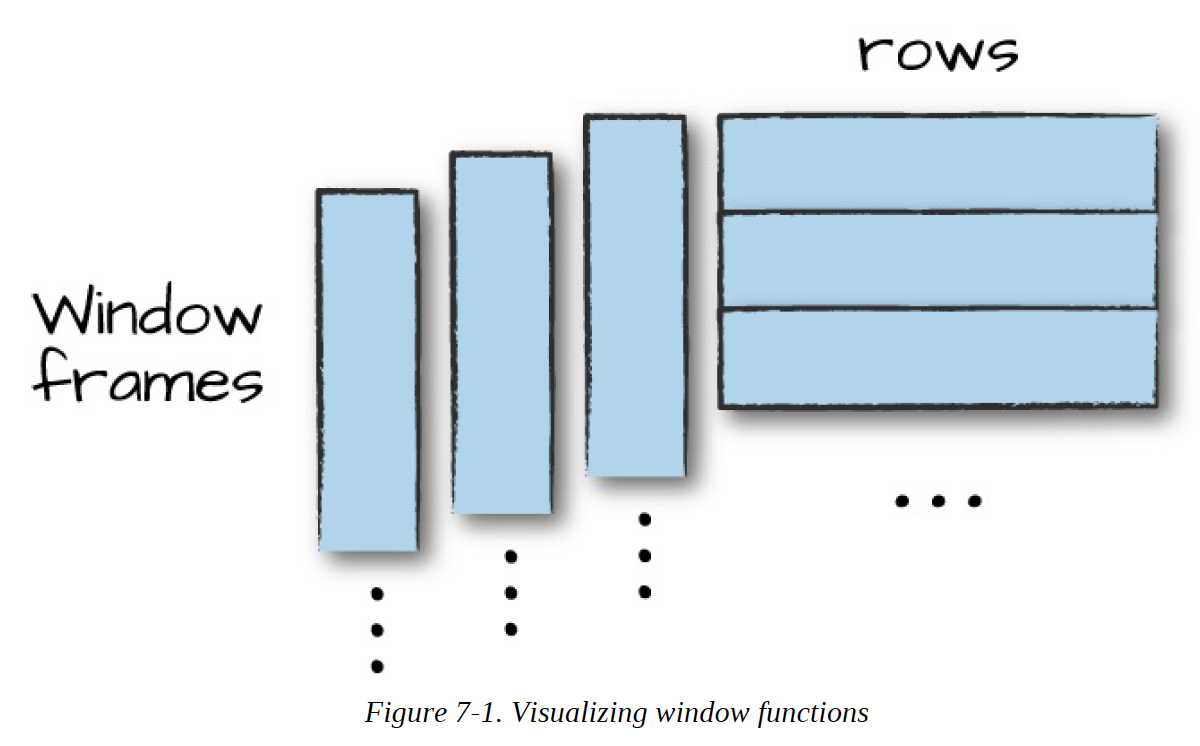
Để chứng minh, chúng tôi sẽ thêm cột ngày sẽ chuyển đổi ngày lập hóa đơn của chúng tôi thành cột chỉ chứa thông tin ngày tháng (không phải thông tin thời gian): 

In [1]:
from pyspark.sql.functions import col, to_date
dfWithDate = df.withColumn("date", to_date(col("InvoiceDate"), "MM/d/yyyy H:mm"))
dfWithDate.createOrReplaceTempView("dfWithDate")

NameError: name 'df' is not defined

Bước đầu tiên đối với chức năng cửa sổ là tạo một đặc tả cửa sổ. Lưu ý rằng phân vùng bởi không liên quan đến khái niệm lược đồ phân vùng mà chúng ta đã đề cập cho đến nay. Nó chỉ là một khái niệm tương tự mô tả cách chúng tôi sẽ chia tay nhóm của mình. Thứ tự xác định thứ tự trong một phân vùng nhất định và cuối cùng là đặc điểm kỹ thuật khung (các hàng tuyên bố) cho biết hàng nào sẽ được đưa vào khung dựa trên tham chiếu của nó đến dòng điện hàng đầu vào. Trong ví dụ sau, chúng tôi xem xét tất cả các hàng trước đó cho đến hàng hiện tại: 

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc
windowSpec = Window\
.partitionBy("CustomerId", "date")\
.orderBy(desc("Quantity"))\
.rowsBetween(Window.unboundedPreceding, Window.currentRow)

Bây giờ chúng tôi muốn sử dụng một hàm tổng hợp để tìm hiểu thêm về từng khách hàng cụ thể. An ví dụ có thể là thiết lập số lượng mua tối đa mọi lúc. Để trả lời điều này, chúng tôi sử dụng cùng một hàm tổng hợp mà chúng ta đã thấy trước đó bằng cách chuyển tên cột hoặc biểu thức. Ngoài ra, chúng tôi cho biết đặc tả cửa sổ xác định khung dữ liệu nào chức năng sẽ áp dụng: 

In [21]:
from pyspark.sql.functions import max
maxPurchaseQuantity = max(col("Quantity")).over(windowSpec)

Bạn sẽ nhận thấy rằng nó trả về một cột (hoặc các biểu thức). Bây giờ chúng ta có thể sử dụng điều này trong DataFrame câu lệnh chọn. Tuy nhiên, trước khi làm như vậy, chúng tôi sẽ tạo thứ hạng số lượng mua. Để làm việc đó chúng tôi sử dụng hàm bold_rank để xác định ngày nào có số lượng mua tối đa cho mọi khách hàng. Chúng tôi sử dụng secure_rank thay vì xếp hạng để tránh khoảng cách trong xếp hạng trình tự khi có các giá trị ràng buộc (hoặc trong trường hợp của chúng tôi là các hàng trùng lặp): 

In [22]:
from pyspark.sql.functions import dense_rank, rank
purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

Điều này cũng trả về một cột mà chúng ta có thể sử dụng trong các câu lệnh chọn. Bây giờ chúng ta có thể thực hiện một lựa chọn để xem các giá trị cửa sổ được tính toán: 

In [23]:
from pyspark.sql.functions import col

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

dfWithDate.where("CustomerId IS NOT NULL").orderBy("CustomerId")\
.select(
col("CustomerId"),
col("date"),
col("Quantity"),
purchaseRank.alias("quantityRank"),
purchaseDenseRank.alias("quantityDenseRank"),
maxPurchaseQuantity.alias("maxPurchaseQuantity")).show()
#-- in SQL
#SELECT CustomerId, date, Quantity,
            #rank(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as rank,
#dense_rank(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as dRank,
#max(Quantity) OVER (PARTITION BY CustomerId, date
            #ORDER BY Quantity DESC NULLS LAST
            #ROWS BETWEEN
            #UNBOUNDED PRECEDING AND
            #CURRENT ROW) as maxPurchase
            #FROM dfWithDate WHERE CustomerId IS NOT NULL ORDER BY CustomerId

+----------+----------+--------+------------+-----------------+-------------------+
|CustomerId|      date|Quantity|quantityRank|quantityDenseRank|maxPurchaseQuantity|
+----------+----------+--------+------------+-----------------+-------------------+
|     12346|2011-01-18|   74215|           1|                1|              74215|
|     12346|2011-01-18|  -74215|           2|                2|              74215|
|     12347|2010-12-07|      36|           1|                1|                 36|
|     12347|2010-12-07|      30|           2|                2|                 36|
|     12347|2010-12-07|      24|           3|                3|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|                 36|
|     12347|2010-12-07|      12|           4|                4|             

# Bộ Nhóm 
Cho đến nay trong chương này, chúng ta đã thấy các biểu thức theo nhóm đơn giản mà chúng ta có thể sử dụng để tổng hợp một tập hợp các cột với các giá trị trong các cột đó. Tuy nhiên, đôi khi chúng ta muốn một chút gì đó đầy đủ hơn — một tập hợp giữa nhiều nhóm. Chúng tôi đạt được điều này bằng cách sử dụng tập hợp nhóm. Tập hợp nhóm là một công cụ cấp thấp để kết hợp các tập hợp tập hợp lại với nhau. Họ cung cấp cho bạn khả năng tạo tập hợp tùy ý trong các câu lệnh theo nhóm của chúng. Chúng ta hãy xem xét một ví dụ để hiểu rõ hơn. Ở đây, chúng tôi muốn lấy tổng số lượng tất cả các mã hàng và khách hàng. Để làm như vậy, chúng tôi sẽ sử dụng SQL sau biểu hiện: 
1. Grouping Sets: Được sử dụng để thực hiện tổng hợp giữa nhiều nhóm. Tập hợp nhóm là một công cụ cấp thấp để kết hợp các tập hợp tập hợp lại với nhau. Chúng cung cấp cho bạn khả năng tạo tổng hợp tùy ý trong các câu lệnh theo nhóm của chúng. 
2. Tập hợp nhóm phụ thuộc vào giá trị null cho các mức tổng hợp. Nếu bạn không lọc ra các giá trị rỗng, bạn sẽ nhận được kết quả không chính xác. Điều này áp dụng cho hình khối, cuộn lên và nhóm nhóm. 
3. Toán tử GROUPING SETS chỉ có sẵn trong SQL. Để thực hiện tương tự trong DataFrames, bạn sử dụng toán tử cuộn lên và cube — cho phép chúng tôi nhận được kết quả tương tự.  
4. Để bao gồm tổng số mặt hàng, bất kể khách hàng hay mã cổ phiếu, chúng tôi chỉ cần chỉ định rằng chúng tôi cũng muốn tổng hợp ở mức đó, trong tập hợp nhóm của chúng tôi. (như thể hiện trong ví dụ tiếp theo). Đây thực chất là sự kết hợp của một số nhóm khác nhau với nhau 

In [27]:
# in Python
dfNoNull = dfWithDate.drop()
dfNoNull.createOrReplaceTempView("dfNoNull")

#-- in SQL
spark.sql("""SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode
ORDER BY CustomerId DESC, stockCode DESC""").show()

+----------+---------+-------------+
|CustomerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



Bạn có thể làm điều tương tự bằng cách sử dụng nhóm nhóm: 

In [28]:
#-- in SQL
spark.sql('''SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode GROUPING SETS((customerId, stockCode))
ORDER BY CustomerId DESC, stockCode DESC''').show()

+----------+---------+-------------+
|customerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



Đủ đơn giản, nhưng điều gì sẽ xảy ra nếu bạn cũng muốn bao gồm tổng số mục, bất kể khách hàng hoặc mã chứng khoán? Với một tuyên bố theo nhóm thông thường, điều này là không thể. Nhưng, thật đơn giản với các nhóm nhóm: chúng tôi chỉ cần xác định rằng chúng tôi muốn tổng hợp ở cấp độ đó, như tốt, trong tập hợp nhóm của chúng tôi. Đây thực chất là sự kết hợp của một số nhóm khác nhau với nhau: 

In [29]:
#-- in SQL
spark.sql('''SELECT CustomerId, stockCode, sum(Quantity) FROM dfNoNull
GROUP BY customerId, stockCode GROUPING SETS((customerId, stockCode),())
ORDER BY CustomerId DESC, stockCode DESC''').show()

+----------+---------+-------------+
|customerId|stockCode|sum(Quantity)|
+----------+---------+-------------+
|     18287|    85173|           48|
|     18287|   85040A|           48|
|     18287|   85039B|          120|
|     18287|   85039A|           96|
|     18287|    84920|            4|
|     18287|    84584|            6|
|     18287|   84507C|            6|
|     18287|   72351B|           24|
|     18287|   72351A|           24|
|     18287|   72349B|           60|
|     18287|    47422|           24|
|     18287|    47421|           48|
|     18287|    35967|           36|
|     18287|    23445|           20|
|     18287|    23378|           24|
|     18287|    23376|           48|
|     18287|    23310|           36|
|     18287|    23274|           12|
|     18287|    23272|           12|
|     18287|    23269|           36|
+----------+---------+-------------+
only showing top 20 rows



Toán tử GROUPING SETS chỉ có sẵn trong SQL. Để thực hiện tương tự trong DataFrames, bạn sử dụng các toán tử cuộn lên và cube — cho phép chúng tôi nhận được kết quả tương tự. Hãy đi qua những, cái đó. 
## Bản tổng hợp 
Cho đến nay, chúng tôi đã xem xét các nhóm rõ ràng. Khi chúng tôi đặt các khóa nhóm gồm nhiều , Spark xem xét các cột đó cũng như các kết hợp thực tế hiển thị trong tập dữ liệu. A cuộn lên là một tập hợp đa chiều thực hiện nhiều phép tính theo nhóm theo kiểu cho chúng tôi. 
Hãy tạo một bản tổng hợp theo thời gian (với cột Ngày mới của chúng tôi) và không gian (với Cột Quốc gia) và tạo một DataFrame mới bao gồm tổng số lớn qua tất cả các ngày, tổng cho mỗi ngày trong DataFrame và tổng phụ cho mỗi quốc gia vào mỗi ngày trong Khung dữ liệu: 

In [30]:
rolledUpDF = dfNoNull.rollup("Date", "Country").agg(sum("Quantity"))\
.selectExpr("Date", "Country", "`sum(Quantity)` as total_quantity")\
.orderBy("Date")
rolledUpDF.show()

+----------+--------------+--------------+
|      Date|       Country|total_quantity|
+----------+--------------+--------------+
|      null|          null|       5176450|
|2010-12-01|          null|         26814|
|2010-12-01|     Australia|           107|
|2010-12-01|        France|           449|
|2010-12-01|United Kingdom|         23949|
|2010-12-01|          EIRE|           243|
|2010-12-01|        Norway|          1852|
|2010-12-01|   Netherlands|            97|
|2010-12-01|       Germany|           117|
|2010-12-02|       Germany|           146|
|2010-12-02|          EIRE|             4|
|2010-12-02|          null|         21023|
|2010-12-02|United Kingdom|         20873|
|2010-12-03|        Poland|           140|
|2010-12-03|        France|           239|
|2010-12-03|       Germany|           170|
|2010-12-03|      Portugal|            65|
|2010-12-03|         Spain|           400|
|2010-12-03|   Switzerland|           110|
|2010-12-03|       Belgium|           528|
+----------

Bây giờ, nơi bạn nhìn thấy các giá trị rỗng là nơi bạn sẽ tìm thấy tổng số. Một rỗng trong cả hai lần cuộn lên các cột chỉ định tổng tổng trên cả hai cột đó: 

In [31]:
rolledUpDF.where("Country IS NULL").show()
rolledUpDF.where("Date IS NULL").show()

+----------+-------+--------------+
|      Date|Country|total_quantity|
+----------+-------+--------------+
|      null|   null|       5176450|
|2010-12-01|   null|         26814|
|2010-12-02|   null|         21023|
|2010-12-03|   null|         14830|
|2010-12-05|   null|         16395|
|2010-12-06|   null|         21419|
|2010-12-07|   null|         24995|
|2010-12-08|   null|         22741|
|2010-12-09|   null|         18431|
|2010-12-10|   null|         20297|
|2010-12-12|   null|         10565|
|2010-12-13|   null|         17623|
|2010-12-14|   null|         20098|
|2010-12-15|   null|         18229|
|2010-12-16|   null|         29632|
|2010-12-17|   null|         16069|
|2010-12-19|   null|          3795|
|2010-12-20|   null|         14965|
|2010-12-21|   null|         15467|
|2010-12-22|   null|          3192|
+----------+-------+--------------+
only showing top 20 rows

+----+-------+--------------+
|Date|Country|total_quantity|
+----+-------+--------------+
|null|   null|      

## Cube 
Một cube đưa việc cuộn lên một cấp độ sâu hơn. Thay vì xử lý các phần tử theo thứ bậc, một cube làm điều tương tự trên tất cả các chiều. Điều này có nghĩa là nó sẽ không chỉ ngày một trôi qua toàn bộ khoảng thời gian, mà còn cả quốc gia. Để đặt lại câu hỏi này, bạn có thể lập bảng bao gồm những điều sau đây? 
1. Tổng số trên tất cả các ngày và quốc gia 
2. Tổng số cho mỗi ngày trên tất cả các quốc gia 
3. Tổng số cho mỗi quốc gia vào mỗi ngày 
4. Tổng số cho mỗi quốc gia trong tất cả các ngày 

Cách gọi phương thức khá giống nhau, nhưng thay vì gọi cuộn lên, chúng ta gọi cube: 

In [32]:
from pyspark.sql.functions import sum
dfNoNull.cube("Date", "Country").agg(sum(col("Quantity")))\
.select("Date", "Country", "sum(Quantity)").orderBy("Date").show()

+----+--------------------+-------------+
|Date|             Country|sum(Quantity)|
+----+--------------------+-------------+
|null|               Japan|        25218|
|null|           Australia|        83653|
|null|            Portugal|        16180|
|null|             Germany|       117448|
|null|                 RSA|          352|
|null|           Hong Kong|         4769|
|null|              Cyprus|         6317|
|null|         Unspecified|         3300|
|null|United Arab Emirates|          982|
|null|                null|      5176450|
|null|     Channel Islands|         9479|
|null|             Finland|        10666|
|null|             Denmark|         8188|
|null|               Spain|        26824|
|null|             Lebanon|          386|
|null|  European Community|          497|
|null|           Singapore|         5234|
|null|              Norway|        19247|
|null|      Czech Republic|          592|
|null|                 USA|         1034|
+----+--------------------+-------

Đây là bản tóm tắt nhanh chóng và dễ dàng truy cập của gần như tất cả thông tin trong bảng của chúng tôi, và đó là một cách tuyệt vời để tạo một bảng tóm tắt nhanh mà những người khác có thể sử dụng sau này. 
## Nhóm Siêu dữ liệu 
Đôi khi khi sử dụng hình khối và cuộn lên, bạn muốn có thể truy vấn các mức tổng hợp để mà bạn có thể dễ dàng lọc chúng cho phù hợp. Chúng tôi có thể làm điều này bằng cách sử dụng grouping_id, cung cấp cho chúng tôi một cột chỉ định mức độ tổng hợp mà chúng tôi có trong tập kết quả của mình. Các truy vấn trong ví dụ sau trả về bốn ID nhóm riêng biệt: 
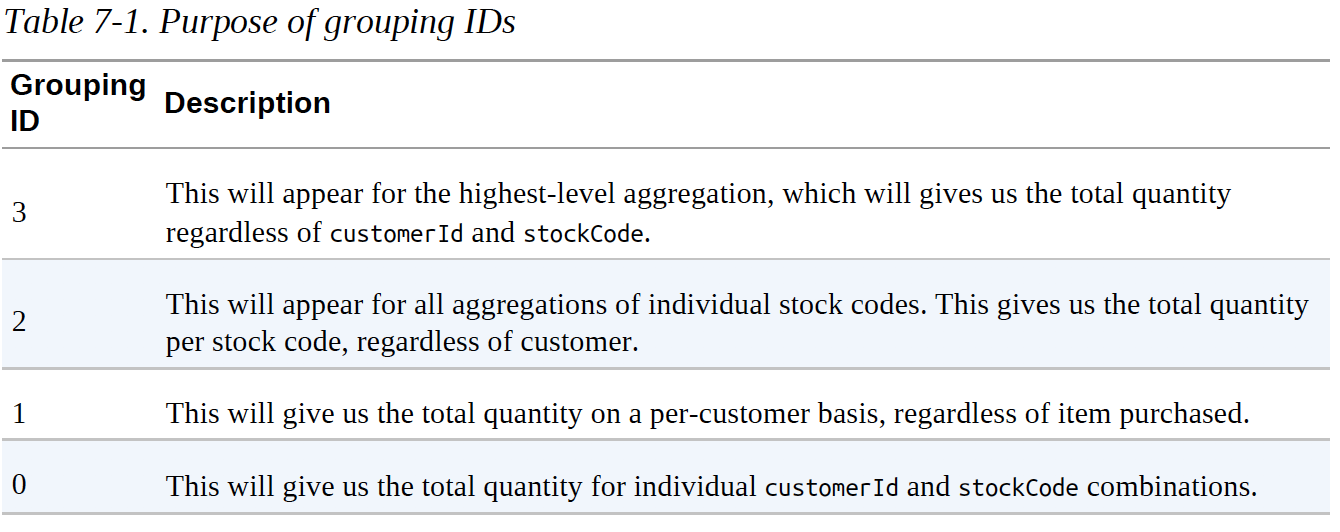 
Điều này hơi trừu tượng, vì vậy bạn nên thử tự tìm hiểu hành vi: 

In [34]:
#// in Scala
#import org.apache.spark.sql.functions.{grouping_id, sum, expr}
#dfNoNull.cube("customerId", "stockCode").agg(grouping_id(), sum("Quantity"))
#.orderBy(expr("grouping_id()").desc)
#.show()

## Pivot
Pivots giúp bạn có thể chuyển đổi một hàng thành một cột. Ví dụ: trong dữ liệu hiện tại của chúng tôi chúng tôi có một cột Quốc gia. Với một pivot, chúng tôi có thể tổng hợp theo một số chức năng cho mỗi của các quốc gia nhất định đó và hiển thị chúng theo cách dễ truy vấn: 

In [35]:
pivoted = dfWithDate.groupBy("date").pivot("Country").sum()

DataFrame này bây giờ sẽ có một cột cho mọi sự kết hợp của quốc gia, biến số, và một cột chỉ định ngày. Ví dụ, đối với Hoa Kỳ, chúng tôi có các cột sau: USA_sum (Số lượng), USA_sum (UnitPrice), USA_sum (CustomerID). Điều này đại diện cho một cho mỗi cột số trong tập dữ liệu của chúng tôi (vì chúng tôi vừa thực hiện tổng hợp trên tất cả chúng). Đây là một truy vấn mẫu và kết quả từ dữ liệu này: 

In [45]:
pivoted.where("date > '2011-12-05'").select("date", "USA_sum(CAST(Quantity AS BIGINT))").show()

+----------+---------------------------------+
|      date|USA_sum(CAST(Quantity AS BIGINT))|
+----------+---------------------------------+
|2011-12-06|                             null|
|2011-12-09|                             null|
|2011-12-08|                             -196|
|2011-12-07|                             null|
+----------+---------------------------------+



# Phần kết luận 
Chương này đã trình bày về các loại và các loại tổng hợp khác nhau mà bạn có thể thực hiện trong Spark. Bạn đã học về các chức năng nhóm thành cửa sổ đơn giản cũng như cuộn lên và hình khối. Chương 8 thảo luận về cách thực hiện phép nối để kết hợp các nguồn dữ liệu khác nhau với nhau. 